# MT with terminology enforcement + informal style Post-Editing
## Task Option: d. Romance language (French) into Slavic language (Russian)

**Dataset**

503 aligned FR-RU segments, manually selected from United Nations Parallel Corpus (overshoot by 3 to make sure the fulltexts of resolutions are fed https://opus.nlpl.eu/UNPC/fr&ru/v1.0/UNPC

Motivation: terminological richness of UN texts, stylistic and terminological uniformity

**Glossary**

A 50-term glossary was extracted manually, based on background knowledge in the domain of international organisations.


**Translation**

**MT:** TowerInstruct-7B-v0.1 https://huggingface.co/Unbabel/TowerInstruct-7B-v0.1

Prompt was based on https://huggingface.co/datasets/Unbabel/TowerBlocks-v0.1/sql-console/h_zeuxO

For each segment, terms were extracted with rapidfuzz fuzzymatch, and stored along with their Russian-language equivalents


***Terminological consistency*** was ensured by adding glossary rules to TowerInstruct prompt. If a segment contained a glossary item, translation rules were added to the prompt message fed to the MT model.

Example:

"Consider the following translation rule(s):\n"Cadre d\'action de Hyogo" --> "–•–∏–æ–≥—Å–∫–∞—è —Ä–∞–º–æ—á–Ω–∞—è –ø—Ä–æ–≥—Ä–∞–º–º–∞ –¥–µ–π—Å—Ç–≤–∏–π".\n"Annexe" --> "–ü—Ä–∏–ª–æ–∂–µ–Ω–∏–µ".\n"D√©claration de Hyogo" --> "–•–∏–æ–≥—Å–∫–∞—è –¥–µ–∫–ª–∞—Ä–∞—Ü–∏—è".\n" 

**Post-Editing:** RuadaptQwen3-4B-Instruct-GGUF (8-bit quantisation) with disabled reasoning 
https://huggingface.co/RefalMachine/RuadaptQwen3-4B-Instruct-GGUF

Selected due to fast inference. Off record, IlyaGusev/saiga_nemo_12b was also checked. While more creative, one minute to process a sentence was not optimal for the available resources.

The experiments were run on Tesla V100 with 32GB VRAM via Grid5000 (student access)

**TLDR resuls**
- ***MT:***
    - COMET score: 0.7687
    - Corpus TER score: 61.06
    - Max segment TER: 500
- ***Informal PE:***
    - COMET score for MTPE: 0.1969
    - Corpus TER score: 86.86
    - Max segment TER: 1600
- **Terminological consistency:**
    - ~77.06% of term instances were featured in MT translations vs 39.63% in PE
    - translations of some terms were less consistent than others (see Terminology adherance section)g

**Possible improvements**
- Select other source text (UN language texts may not have been originally written in French)
- Input text preprocessing (cleaning, adding  missing spaces between words)
- Terminological consistancy ensurance:
  - Automatic Term Extraction
  - run queries to UNTERM portal/use existng (larger) UN term base
  - actual RAG pipeline (not tried due to time constraints), not merely prompting
- LLM MTPE output postprocessing:
  - removing additions "–§—Ä–∞–Ω—Ü—É–∑—Å–∫–∏–π: I. –û–±—ä–µ–∫—Ç"	--> "I. –û–±—ä–µ–∫—Ç"
  - ensuring correct capitalisation conventions: "–ü—Ä–∏ —ç—Ç–æ–º —Ç–∞–∫–∂–µ –Ω–∞–ø–æ–º–∏–Ω–∞—è –æ —Å–≤–æ–∏—Ö —Ä–µ–∑–æ–ª—é—Ü–∏—è—Ö, –∫–∞—Å–∞—é—â–∏—Ö—Å—è –∫—É–ª—å—Ç—É—Ä—ã –º–∏—Ä–∞,.." --> "–ø—Ä–∏ —ç—Ç–æ–º —Ç–∞–∫–∂–µ –Ω–∞–ø–æ–º–∏–Ω–∞—è –æ —Å–≤–æ–∏—Ö —Ä–µ–∑–æ–ª—é—Ü–∏—è—Ö, –∫–∞—Å–∞—é—â–∏—Ö—Å—è –∫—É–ª—å—Ç—É—Ä—ã –º–∏—Ä–∞,..
- Informal PE
  - larger model?"


## Imports

In [1]:
import warnings
warnings.filterwarnings("ignore", message="The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.")

In [2]:
import pandas as pd
import re
import pandas as pd
import numpy as np
import torch
import re
from rapidfuzz import fuzz

import copy
import ast
from pathlib import Path

from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM
from datasets import Dataset
from tqdm import tqdm
import gc


from llama_cpp import Llama


from comet import download_model, load_from_checkpoint
from sacrebleu.metrics import TER
from sacrebleu import corpus_ter

/home/solga/public/Tproj/venvT/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/solga/public/Tproj/venvT/lib/python3.9/site-packages/torchmetrics/utilities/imports.py:23: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [73]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
sentences = Path("data/UN.fr").read_text(encoding="utf-8").strip().split("\n")
sentences[:12]

['R√âSOLUTION 62/88',
 "Adopt√©e √† la 73e s√©ance pl√©ni√®re, le 13 d√©cembre 2007, sans avoir √©t√© mise aux voix, sur la base du projet de r√©solution A/62/L.31, pr√©sent√© par le Pr√©sident de l'Assembl√©e g√©n√©rale",
 "62/88. D√©claration de la s√©ance pl√©ni√®re comm√©morative de haut niveau sur les suites donn√©es √† la session extraordinaire de l'Assembl√©e g√©n√©rale consacr√©e aux enfants",
 "L'Assembl√©e g√©n√©rale",
 'Adopte la d√©claration suivante :',
 "D√©claration de la s√©ance pl√©ni√®re comm√©morative de haut niveau sur les suites donn√©es √† la session extraordinaire de l'Assembl√©e g√©n√©rale consacr√©e aux enfants",
 "1. Nous, repr√©sentants des √âtats rassembl√©s √† la s√©ance pl√©ni√®re comm√©morative de haut niveau de l'Assembl√©e g√©n√©rale, sommes encourag√©s par les avanc√©es r√©alis√©es depuis 2002 sur la voie de la cr√©ation d'un monde digne des enfants. Le nombre d'enfants de moins de 5 ans qui meurent chaque ann√©e a diminu√©. Jamais autant d'enfants n'o

## Machine translation

In [ ]:
# ------------Parameters--------------
SOURCE_FILE = "data/UN-Copy1.fr"
REFERENCE_FILE = "data/UN-Copy1.ru"
GLOSSARY_FILE = "data/glossary.csv"
OUTPUT_FILE = "data/UN-Copy1.mt"
OUTPUT_FILE_PE = "data/UN_to_informal.txt"

MODEL_ID = "Unbabel/TowerInstruct-v0.1"
BATCH_SIZE = 8
MAX_NEW_TOKENS = 1256

FUZZY_THRESHOLD = 85

In [24]:
# Load model and tokenizer
pipe = pipeline("text-generation", model=MODEL_ID, torch_dtype=torch.bfloat16, device_map="auto", do_sample=False)
tokenizer = pipe.tokenizer

We will use 90% of the memory on device 0 for storing the model, and 10% for the buffer to avoid OOM. You can set `max_memory` in to a higher value to use more memory (at your own risk).
Loading checkpoint shards: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 6/6 [00:07<00:00,  1.19s/it]
Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


In [25]:
# -----------Load sentences------------
with open(SOURCE_FILE, encoding="utf-8") as f:
    sentences = [line.strip() for line in f if line.strip()]
with open(REFERENCE_FILE, encoding="utf-8") as f:
    references = [line.strip() for line in f if line.strip()]

# ------------Load glossary--------------
glossary_df = pd.read_csv(GLOSSARY_FILE, encoding="utf-8", names=['FR','RU'], header=None).dropna()
glossary_dict = dict(zip(glossary_df.FR, glossary_df.RU))
terms = glossary_df['FR'].dropna().unique().tolist()
regex_terms = [re.escape(t.lower()) for t in terms]

# -------------Function to find glossary terms in a sentence---------------
def find_terms_in_sentence(sentence, terms, regex_terms):
    sentence_lower = sentence.lower()
    matched_terms = set()
    for term, regex_term in zip(terms, regex_terms):
        pattern = r'\b' + regex_term + r'\b'
        if re.search(pattern, sentence_lower):
            matched_terms.add(term)
        else:
            score = fuzz.partial_ratio(term.lower(), sentence_lower)
            if score >= FUZZY_THRESHOLD:
                matched_terms.add(term)
    return list(matched_terms)

# -----------Dataset assembly--------------------
data = []
for idx, sentence in enumerate(sentences):
    source_terms = find_terms_in_sentence(sentence, terms, regex_terms)
    ref = references[idx] if idx < len(references) else ""
    target_terms = [glossary_dict[t] for t in source_terms if t in glossary_dict]
    data.append({
        "index": idx,
        "sentence": sentence,
        "ref": ref,
        "terms_source": source_terms,
        "terms_target": target_terms,
    })

ds = Dataset.from_list(data)

In [26]:
def build_prompt(example):
    sentence = example["sentence"]
    idx = example["index"]
    terms_src = example["terms_source"]
    terms_tgt = example["terms_target"]
    sentence_lower = sentence.lower()

    glossary_instruction = ""

    if terms_src:
        glossary_rules = []
        for fr_term, ru_term in zip(terms_src, terms_tgt):
            glossary_rules.append(f'"{fr_term}" --> "{ru_term}".')
        glossary_instruction = "Consider the following translation rule(s):\n" + "\n".join(glossary_rules)

    prompt = f"""
{glossary_instruction}
Translate the following sentence from French to Russian.

French: {sentence}
Russian:"""

    messages = [{"role": "user", "content": prompt.strip()}]
    full_prompt = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)

    return {"prompt": full_prompt}

# Applying prompts to dataset
ds = ds.map(build_prompt)



Map: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 503/503 [00:00<00:00, 6362.96 examples/s]


In [31]:
ds[86]

{'index': 86,
 'sentence': "Rappelant la D√©claration de HyogoA/CONF.206/6, chap. I, r√©solution 1. et le Cadre d'action de Hyogo pour 2005-2015Cadre d'action de Hyogo pour 2005-2015 : Pour des nations et des collectivit√©s r√©silientes face aux catastrophes (A/CONF.206/6, chap. I, r√©solution 2)., ainsi que la d√©claration commune publi√©e √† l'issue de la session extraordinaire sur la catastrophe de l'oc√©an IndienD√©claration commune publi√©e √† l'issue de la session extraordinaire sur la catastrophe de l'oc√©an Indien : r√©duire les risques pour un avenir plus s√ªr (A/CONF.206/6, annexe II)., adopt√©s par la Conf√©rence mondiale sur la pr√©vention des catastrophes tenue √† Kobe, dans la pr√©fecture de Hyogo (Japon), du 18 au 22 janvier 2005,",
 'ref': '—Å—Å—ã–ª–∞—è—Å—å –Ω–∞ –•–∏–æ–≥—Å–∫—É—é –¥–µ–∫–ª–∞—Ä–∞—Ü–∏—éA/CONF.206/6, –≥–ª–∞–≤–∞ I, —Ä–µ–∑–æ–ª—é—Ü–∏—è 1. –∏ –•–∏–æ–≥—Å–∫—É—é —Ä–∞–º–æ—á–Ω—É—é –ø—Ä–æ–≥—Ä–∞–º–º—É –¥–µ–π—Å—Ç–≤–∏–π –Ω–∞ 2005-2015 –≥–æ–¥—ã–•–∏–æ–≥—Å–∫–∞—è —Ä–∞–º–æ—á–

In [8]:
BATCH_SIZE = 16
MAX_SENTENCES = len(ds)  # len(ds) if using the whole dataset
all_translations = []

num_batches = (MAX_SENTENCES + BATCH_SIZE - 1) // BATCH_SIZE

# -------- Running batched inference ----------------------
for i in tqdm(range(0, MAX_SENTENCES, BATCH_SIZE), total=num_batches, desc="Translating", unit="batch"):
    start_time = time.time()

    batch = ds[i:i + BATCH_SIZE]
    prompts = batch["prompt"]
    outputs = pipe(prompts, max_new_tokens=MAX_NEW_TOKENS, do_sample=False)

    for output_group in outputs:
        output = output_group[0]
        text = output["generated_text"]

        if "<|im_start|>assistant" in text:
            translation = text.split("<|im_start|>assistant")[-1].strip()
        else:
            translation = text.strip()

        translation = translation.split("<|")[0].strip()
        all_translations.append(translation)


Translating:   0%|          | 0/32 [00:00<?, ?batch/s]The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The foll

### (skip the verbosity) 
### Saving to file 

In [9]:
# Save to file
Path(OUTPUT_FILE).write_text("\n".join(all_translations), encoding="utf-8")
print(f"‚úÖ {len(all_translations)} translations written to {OUTPUT_FILE}")

# Free memory
del pipe, tokenizer, outputs, ds
gc.collect()
torch.cuda.empty_cache()
torch

‚úÖ 503 translations written to data/UN-Copy1.mt


<module 'torch' from '/home/solga/public/Tproj/venvT/lib/python3.9/site-packages/torch/__init__.py'>

In [ ]:
fr_terms_to_csv = list(ds[:]['terms_source'])
ru_terms_to_csv = list(ds[:]['terms_target'])

## MT evaluation

### COMET

In [10]:
model_path = download_model("wmt20-comet-da")
modelEVAL = load_from_checkpoint(model_path)

/home/solga/public/Tproj/venvT/lib/python3.9/site-packages/torchmetrics/utilities/imports.py:23: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
wmt20-comet-da is already in cache.
Lightning automatically upgraded your loaded checkpoint from v1.3.5 to v2.5.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../.cache/torch/unbabel_comet/wmt20-comet-da/checkpoints/model.ckpt`
Encoder model frozen.
/home/solga/public/Tproj/venvT/lib/python3.9/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']


In [11]:
cometdata = [
    {"src": s, "mt": m, "ref": r}
    for s, m, r in zip(sentences, all_translations, references)
]

model_output = modelEVAL.predict(cometdata, batch_size=8, gpus=1)  # or gpus=0 for CPU

# List of segment-level scores
segment_scores = model_output["scores"]

# Optional: average score
average_score = sum(segment_scores) / len(segment_scores)
print(f"COMET score: {average_score:.4f}")

üí° Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Predicting DataLoader 0: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 63/63 [00:09<00:00,  6.44it/s]


COMET score: 0.7687


In [42]:
fr_terms_to_csv = list(ds[:]['terms_source'])
ru_terms_to_csv = list(ds[:]['terms_target'])

### TER

In [22]:
ter_corpus = corpus_ter(all_translations, [references])
print(f"Corpus TER score: {ter_corpus.score:.2f}")

Corpus TER score: 61.06


In [18]:
ter_metric = TER()
scores = [ter_metric.sentence_score(m, [r]).score for m, r in zip(all_translations, references)]

df = pd.DataFrame({
    "MT Output": all_translations,
    "Reference": references,
    "TER": scores
})

df.sort_values("TER", ascending=False).head(12) 

MT Output  \
58   –ü—Ä–∏–Ω—è—Ç–∞ –Ω–∞ 74-–π –ø–ª–µ–Ω–∞—Ä–Ω–æ–º –∑–∞—Å–µ–¥–∞–Ω–∏–∏ 17 –¥–µ–∫–∞–±—Ä—è...   
421  –ü—Ä–∏–Ω—è—Ç–∞ –Ω–∞ 75-–π –ø–ª–µ–Ω–∞—Ä–Ω–æ–π —Å–µ—Å—Å–∏–∏ 17 –¥–µ–∫–∞–±—Ä—è 20...   
294  –í —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤–∏–∏ —Å –£—Å—Ç–∞–≤–æ–º –û—Ä–≥–∞–Ω–∏–∑–∞—Ü–∏–∏ –û–±—ä–µ–¥–∏–Ω–µ–Ω...   
260  constatando la importancia de mantener estrech...   
124  constatando la importancia de la cooperaci√≥n i...   
256  constatando con profunda preocupaci√≥n que las ...   
68   –ø–æ–¥—Ç–≤–µ—Ä–∂–¥–∞—è –≤–∞–∂–Ω–æ—Å—Ç—å –ø–æ–¥–¥–µ—Ä–∂–∫–∏ —É—Å–∏–ª–∏–π, –Ω–∞–ø—Ä–∞–≤–ª...   
189  11. –ø—Ä–æ—Å–∏—Ç –º–µ–∂–¥—É–Ω–∞—Ä–æ–¥–Ω–æ–µ —Å–æ–æ–±—â–µ—Å—Ç–≤–æ –¥–æ–Ω–æ—Ä–æ–≤ –æ–∫...   
340                 –ó–∞–∫–ª—é—á–∏–ª–∏ —Å–ª–µ–¥—É—é—â–∏–µ –æ–±—è–∑–∞—Ç–µ–ª—å—Å—Ç–≤–∞:   
341                             –§—Ä–∞–Ω—Ü—É–∑—Å–∫–∏–π: I. –û–±—ä–µ–∫—Ç   
93   –æ—Ç–º–µ—á–∞—è, —á—Ç–æ –∑–∞—Ç—Ä–æ–Ω—É—Ç—ã–µ —Ü—É–Ω–∞–º–∏ —Å—Ç—Ä–∞–Ω—ã –ø—Ä–æ–¥–≤–∏–Ω—É...   
69              –ó–Ω–∞—è, —á—Ç–æ –≤—Å–µ —Ä–µ–ª–∏–≥–∏–∏ –ø—Ä–∏–≤–µ—Ä–∂–µ–Ω—ã –º–∏—Ä—É,   

                                             Reference         TER  
58   –ü—Ä–∏–Ω—è—Ç–∞ –±–µ–∑ –≥–æ–ª–æ—Å–æ–≤–∞–Ω–∏—è –Ω–∞ 74-–º –ø–ª–µ–Ω–∞—Ä–Ω–æ–º –∑–∞—Å–µ...  500.000000  
421  –ü—Ä–∏–Ω—è—Ç–∞ –±–µ–∑ –≥–æ–ª–æ—Å–æ–≤–∞–Ω–∏—è –Ω–∞ 75-–º –ø–ª–µ–Ω–∞—Ä–Ω–æ–º –∑–∞—Å–µ...  306.000000  
294  —Ä—É–∫–æ–≤–æ–¥—Å—Ç–≤—É—è—Å—å –£—Å—Ç–∞–≤–æ–º –û—Ä–≥–∞–Ω–∏–∑–∞—Ü–∏–∏ –û–±—ä–µ–¥–∏–Ω–µ–Ω–Ω—ã...  138.461538  
260  –æ—Ç–º–µ—á–∞—è –≤–∞–∂–Ω–æ—Å—Ç—å –ø–æ–¥–¥–µ—Ä–∂–∞–Ω–∏—è —Ç–µ—Å–Ω–æ–≥–æ –≤–∑–∞–∏–º–æ–¥–µ–π...  129.268293  
124  –ø—Ä–∏–∑–Ω–∞–≤–∞—è –≤–∞–∂–Ω–æ—Å—Ç—å –º–µ–∂–¥—É–Ω–∞—Ä–æ–¥–Ω–æ–≥–æ —Å–æ—Ç—Ä—É–¥–Ω–∏—á–µ—Å—Ç...  125.000000  
256  –≤—ã—Ä–∞–∂–∞—è –≥–ª—É–±–æ–∫—É—é –æ–∑–∞–±–æ—á–µ–Ω–Ω–æ—Å—Ç—å –ø–æ –ø–æ–≤–æ–¥—É —Ç–æ–≥–æ,...  119.444444  
68   –ø–æ–¥—Ç–≤–µ—Ä–∂–¥–∞—è –±–æ–ª—å—à–æ–µ –∑–Ω–∞—á–µ–Ω–∏–µ –ø—Ä–æ–¥–æ–ª–∂–µ–Ω–∏—è –ø—Ä–æ—Ü–µ...  109.090909  
189  11. –ø—Ä–∏–∑—ã–≤–∞–µ—Ç –º–µ–∂–¥—É–Ω–∞—Ä–æ–¥–Ω–æ–µ —Å–æ–æ–±—â–µ—Å—Ç–≤–æ –¥–æ–Ω–æ—Ä–æ–≤...  100.000000  
340                      –¥–æ–≥–æ–≤–æ—Ä–∏–ª–∏—Å—å –æ –Ω–∏–∂–µ—Å–ª–µ–¥—É—é—â–µ–º:  100.000000  
341                                  I. –ü—Ä–µ–¥–Ω–∞–∑–Ω–∞—á–µ–Ω–∏–µ  100.000000  
93   –æ—Ç–º–µ—á–∞—è –ø—Ä–æ–≥—Ä–µ—Å—Å –≤ –æ–±–ª–∞—Å—Ç–∏ –≤–æ—Å—Å—Ç–∞–Ω–æ–≤–ª–µ–Ω–∏—è, –¥–æ—Å...  100.000000  
69    –ø—Ä–∏–∑–Ω–∞–≤–∞—è –ø—Ä–∏–≤–µ—Ä–∂–µ–Ω–Ω–æ—Å—Ç—å –≤—Å–µ—Ö —Ä–µ–ª–∏–≥–∏–π –¥–µ–ª—É –º–∏—Ä–∞,  100.000000

## write to csv > xslx: MT

In [49]:
res_data = {
    "FR": sentences,
    "RU_GOLD": references,
    "RU_MT": all_translations,
    "FR_TERMS": fr_terms_to_csv,
    "RU_TERMS_GOLD": ru_terms_to_csv,
    "COMET_MT": segment_scores,
    "TER_MT": scores
}

res = pd.DataFrame(res_data)
res.to_csv("result.csv", index=False, encoding="utf-8")


## MTPE

## MTPE to infor,ql stylewith RuadaptQwen3-4B-Instruct-GGUF

In [58]:
# MTPE model
llm = Llama.from_pretrained(
    repo_id="RefalMachine/RuadaptQwen3-4B-Instruct-GGUF",
    filename="Q8_0.gguf",  # "BF16.gguf", "IQ3_S.gguf", "IQ3_XS.gguf", "IQ4_NL.gguf", "IQ4_XS.gguf", "Q2_K.gguf", "Q3_K_M.gguf", "Q3_K_S.gguf", "Q4_0.gguf", "Q4_K_M.gguf", "Q4_K_S.gguf", "Q5_0.gguf", "Q5_K_M.gguf", "Q5_K_S.gguf", "Q6_K.gguf", "Q8_0.gguf"
    n_ctx=2048,
    n_gpu_layers=-1, 
    verbose=False    
)


llama_context: n_ctx_per_seq (2048) < n_ctx_train (40960) -- the full capacity of the model will not be utilized
llama_kv_cache_unified: LLAMA_SET_ROWS=0, using old ggml_cpy() method for backwards compatibility


In [103]:
system_prompt = "<|im_start|>system\n–¢—ã —Ä–µ–¥–∞–∫—Ç–æ—Ä, –∫–æ—Ç–æ—Ä—ã–π –ø–µ—Ä–µ–ø–∏—Å—ã–≤–∞–µ—Ç —Ñ–æ—Ä–º–∞–ª—å–Ω—ã–µ —Ä—É—Å—Å–∫–∏–µ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏—è –≤ —Ä–∞—Å—Å–ª–∞–±–ª–µ–Ω–Ω–æ–º —Ä–∞–∑–≥–æ–≤–æ—Ä–Ω–æ–º —Å—Ç–∏–ª–µ. –í –æ—Ç–≤–µ—Ç–µ —É–∫–∞–∂–∏ —Ç–æ–ª—å–∫–æ —Ä–∞–∑–≥–æ–≤–æ—Ä–Ω–æ–µ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏–µ, –±–µ–∑ –æ–±—ä—è—Å–Ω–µ–Ω–∏–π<|im_end|>\n"


user_prefix = "<|im_start|>user\–°–¥–µ–ª–∞–π —Ä–∞—Å—Å–ª–∞–±–ª–µ–Ω–Ω—É—é —Ä–∞–∑–≥–æ–≤–æ—Ä–Ω—É—é –≤–µ—Ä—Å–∏—é —ç—Ç–æ–≥–æ –ø—Ä–µ–¥–ª–æ–∂–µ–Ω–∏—è:\n"


assistant_prefix = "<|im_end|>\n<|im_start|>assistant\n"

In [104]:
sent = "–ù–µ—Å–º–æ—Ç—Ä—è –Ω–∞ –¥–æ—Å—Ç–∏–≥–Ω—É—Ç—ã–µ –æ–±–Ω–∞–¥–µ–∂–∏–≤–∞—é—â–∏–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã, –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –¥–µ—Ç–µ–π, —É–º–∏—Ä–∞—é—â–∏—Ö –¥–æ –¥–æ—Å—Ç–∏–∂–µ–Ω–∏—è –ø—è—Ç–∏–ª–µ—Ç–Ω–µ–≥–æ –≤–æ–∑—Ä–∞—Å—Ç–∞, –æ—Å—Ç–∞–µ—Ç—Å—è –Ω–µ–ø—Ä–∏–µ–º–ª–µ–º—ã–º."
prompt = "{}{}{} /no_think{}".format(system_prompt, user_prefix, sent, assistant_prefix)

output = llm(
    prompt,
    max_tokens=512,
    temperature=0.1,
    top_p=0.85,
    stop=["<|im_end|>"]
)

In [105]:
output['choices'][0]['text']

'\n\n\n\n–î–∞–∂–µ –µ—Å–ª–∏ —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã —Ö–æ—Ä–æ—à–∏–µ, –¥–µ—Ç–∏ –¥–æ –ø—è—Ç–∏ –ª–µ—Ç –≤—Å—ë –µ—â—ë —É–º–∏—Ä–∞—é—Ç —Å–ª–∏—à–∫–æ–º –º–Ω–æ–≥–æ ‚Äî —ç—Ç–æ –ø—Ä–æ—Å—Ç–æ —É–∂–∞—Å–Ω–æ.'

In [46]:
with open("data/UN-Copy1.mt", "r", encoding="utf-8") as f:
    formal_sentences = [line.strip() for line in f if line.strip()]

In [106]:
informal_MTPE = []

with open(OUTPUT_FILE_PE, "w", encoding="utf-8") as out_file:

    for sent in tqdm(formal_sentences, desc="To informal"):
        # building prompt with /no_think at the end of user message
        prompt = "{}{}{} /no_think{}".format(system_prompt, user_prefix, sent, assistant_prefix)
        
        output = llm(
            prompt,
            max_tokens=512,
            temperature=0.1,
            top_p=0.85,
            stop=["<|im_end|>"]
        )
        
        informal = output["choices"][0]["text"].strip().replace("\t", " ").replace("\n", " ")
        informal_MTPE.append(informal)

        out_file.write(f"{informal}\n")

To informal: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 503/503 [43:29<00:00,  5.19s/it] 


## PE evaluation

### COMET

In [107]:
model_path = download_model("wmt20-comet-da")
modelEVAL = load_from_checkpoint(model_path)

cometdata_PE = [
    {"src": s, "mt": m, "ref": r}
    for s, m, r in zip(sentences, informal_MTPE, references)
]

model_output_PE = modelEVAL.predict(cometdata_PE, batch_size=8, gpus=1)

# List of segment-level scores
segment_scores_PE = model_output_PE["scores"]

# Average score
average_score = sum(segment_scores_PE) / len(segment_scores_PE)
print(f"COMET score for MTPE: {average_score:.4f}")

wmt20-comet-da is already in cache.
Lightning automatically upgraded your loaded checkpoint from v1.3.5 to v2.5.2. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint ../../.cache/torch/unbabel_comet/wmt20-comet-da/checkpoints/model.ckpt`
Encoder model frozen.
/home/solga/public/Tproj/venvT/lib/python3.9/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['encoder.model.embeddings.position_ids']
üí° Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Predicting DataLoader 0: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 63/63 [00:15<00:00,  4.00it/s]


COMET score for MTPE: 0.1969


### TER

In [108]:
ter_corpus_PE = corpus_ter(informal_MTPE, [references])
print(f"Corpus TER score: {ter_corpus_PE.score:.2f}")

ter_metric = TER()
scores_MTPE = [ter_metric.sentence_score(m, [r]).score for m, r in zip(informal_MTPE, references)]

df = pd.DataFrame({
    "MTPE Output": informal_MTPE,
    "Reference": references,
    "TER": scores_MTPE
})

df.sort_values("TER", ascending=False).head(12) 

Corpus TER score: 86.86


MTPE Output  \
153  –†–µ–∑–æ–ª—é—Ü–∏—è 62/93 ‚Äî —ç—Ç–æ –¥–æ–∫—É–º–µ–Ω—Ç –û–û–ù, –∫–æ—Ç–æ—Ä—ã–π –±—ã...   
325  –ü—Ä–∏–ª–æ–∂–µ–Ω–∏–µ ‚Äî —ç—Ç–æ –∫–∞–∫ —Ç–≤–æ–π –ª–∏—á–Ω—ã–π –ø–æ–º–æ—â–Ω–∏–∫, –∫–æ—Ç...   
450  –†–ï–ó–û–õ–Æ–¶–ò–Ø 62/9 ‚Äî —ç—Ç–æ –ø—Ä–æ—Å—Ç–æ –æ—á–µ—Ä–µ–¥–Ω–æ–π –¥–æ–∫—É–º–µ–Ω—Ç...   
483  –†–µ—à–µ–Ω–∏–µ ‚Ññ55/101, –∫–æ—Ä–æ—á–µ –≥–æ–≤–æ—Ä—è, ‚Äî —ç—Ç–æ –¥–æ–∫—É–º–µ–Ω—Ç...   
50   –†–ï–ó–û–õ–Æ–¶–ò–Ø 62/8 ‚Äî —ç—Ç–æ –¥–æ–∫—É–º–µ–Ω—Ç –û–û–ù, –∫–æ—Ç–æ—Ä—ã–π –ø—Ä–∏...   
243  –ì–µ–Ω–µ—Ä–∞–ª—å–Ω–∞—è –ê—Å—Å–∞–º–±–ª–µ—è ‚Äî —ç—Ç–æ –∫–∞–∫ –≥–ª–∞–≤–Ω—ã–π —Å–æ–≤–µ—Ç ...   
0    –†–µ—à–µ–Ω–∏–µ ‚Ññ62/88 ‚Äî —ç—Ç–æ –ø—Ä–æ—Å—Ç–æ –¥–æ–∫—É–º–µ–Ω—Ç, –∫–æ—Ç–æ—Ä—ã–π ...   
359  –ì–ª–æ–±–∞–ª—å–Ω–∞—è —Ü–µ–ª—å ‚Äî —ç—Ç–æ –∫–æ–≥–¥–∞ –≤—Å–µ –≤–º–µ—Å—Ç–µ —Å—Ç–∞—Ä–∞–µ–º...   
423  –ì–µ–Ω–µ—Ä–∞–ª—å–Ω–∞—è –ê—Å—Å–∞–º–±–ª–µ—è ‚Äî —ç—Ç–æ —Ç–∞ —Å–∞–º–∞—è –æ—Ñ–∏—Ü–∏–∞–ª—å–Ω...   
361  –ì–ª–æ–±–∞–ª—å–Ω–∞—è —Ü–µ–ª—å ‚Äî —ç—Ç–æ –∫–æ–≥–¥–∞ –≤—Å–µ –≤–º–µ—Å—Ç–µ —Å—Ç–∞—Ä–∞–µ–º...   
319  –ì–µ–Ω–µ—Ä–∞–ª—å–Ω–∞—è –ê—Å—Å–∞–º–±–ª–µ—è ‚Äî —ç—Ç–æ –∫–∞–∫ –≥–ª–∞–≤–Ω—ã–π —Å–æ–≤–µ—Ç ...   
53   –ì–µ–Ω–µ—Ä–∞–ª—å–Ω–∞—è –ê—Å—Å–∞–º–±–ª–µ—è ‚Äî —ç—Ç–æ –∫–∞–∫ –≥–ª–∞–≤–Ω—ã–π —Å–æ–≤–µ—Ç ...   

                  Reference          TER  
153         –†–ï–ó–û–õ–Æ–¶–ò–Ø 62/93  1600.000000  
325              –ü—Ä–∏–ª–æ–∂–µ–Ω–∏–µ  1300.000000  
450          –†–ï–ó–û–õ–Æ–¶–ò–Ø 62/9  1050.000000  
483        –†–ï–ó–û–õ–Æ–¶–ò–Ø 55/101   850.000000  
50           –†–ï–ó–û–õ–Æ–¶–ò–Ø 62/8   850.000000  
243  –ì–µ–Ω–µ—Ä–∞–ª—å–Ω–∞—è –ê—Å—Å–∞–º–±–ª–µ—è,   800.000000  
0           –†–ï–ó–û–õ–Æ–¶–ò–Ø 62/88   800.000000  
359       –ì–ª–æ–±–∞–ª—å–Ω–∞—è —Ü–µ–ª—å 1   733.333333  
423  –ì–µ–Ω–µ—Ä–∞–ª—å–Ω–∞—è –ê—Å—Å–∞–º–±–ª–µ—è,   700.000000  
361       –ì–ª–æ–±–∞–ª—å–Ω–∞—è —Ü–µ–ª—å 2   700.000000  
319  –ì–µ–Ω–µ—Ä–∞–ª—å–Ω–∞—è –ê—Å—Å–∞–º–±–ª–µ—è,   650.000000  
53   –ì–µ–Ω–µ—Ä–∞–ª—å–Ω–∞—è –ê—Å—Å–∞–º–±–ª–µ—è,   650.000000

## Write results to file

In [109]:
res = pd.read_csv("result.csv")

# ---------Adding new columns
res["RU_PE"] = informal_MTPE
res["COMET_PE"] = segment_scores_PE
res["TER_PE"] = scores_MTPE

res.to_csv("result_with_mtpe.csv", index=False, encoding="utf-8")

In [32]:
columns_to_save = ['FR', 'RU_GOLD', 'RU_MT', 'RU_PE']

res.to_excel("results_mt_pe.xlsx", columns=columns_to_save, index=False, header=False)


## Terminology adherance

In [21]:
import ast

In [22]:
res["FR_TERMS"] = res["FR_TERMS"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
res["RU_TERMS_GOLD"] = res["RU_TERMS_GOLD"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


In [23]:
def find_missing_terms(mt_text, ru_terms, threshold=85):
    """
    Return list of terms from ru_terms that are NOT fuzzy-matched in mt_text.
    A term is considered matched if a substring in mt_text has a similarity >= threshold.
    """
    missing = []
    for term in ru_terms:
        score = fuzz.partial_ratio(term.lower(), mt_text.lower())
        if score < threshold:
            missing.append(term)
    return missing


In [24]:
res["missing_terms"] = res.apply(lambda row: find_missing_terms(row["RU_MT"], row["RU_TERMS_GOLD"]), axis=1)
res["missing_terms_PE"] = res.apply(lambda row: find_missing_terms(row["RU_PE"], row["RU_TERMS_GOLD"]), axis=1)

In [19]:
res["missing_terms"][114:134] 

114                                              []
115                           [–ø–ª–µ–Ω–∞—Ä–Ω–æ–µ –∑–∞—Å–µ–¥–∞–Ω–∏–µ]
116                                              []
117                                              []
118                                              []
119                                              []
120    [–†–ï–ó–û–õ–Æ–¶–ò–Ø, –ü—Ä–∏–ª–æ–∂–µ–Ω–∏–µ, –•–∏–æ–≥—Å–∫–∞—è –¥–µ–∫–ª–∞—Ä–∞—Ü–∏—è]
121                                              []
122                                              []
123                                              []
124                                              []
125                                              []
126                                              []
127                                              []
128                                              []
129                                              []
130                                              []
131                                              []
132      

In [25]:
res["num_missed_terms"] = res["missing_terms"].apply(len)
res["num_missed_terms_PE"] = res["missing_terms_PE"].apply(len)

In [27]:
total_terms = res["RU_TERMS_GOLD"].apply(len).sum()
total_missed = res["num_missed_terms"].sum()
consistency_rate = 1 - (total_missed / total_terms)
total_missed_PE = res["num_missed_terms_PE"].sum()
consistency_rate_PE = 1 - (total_missed_PE / total_terms)

print(f"Total term instances: {total_terms}")
print(f"Missed terms MT: {total_missed}")
print(f"Terminological consistency rate MT: {consistency_rate:.2%}")
print(f"Missed terms PE: {total_missed_PE}")
print(f"Terminological consistency rate MT: {consistency_rate_PE:.2%}")


Total term instances: 545
Missed terms MT: 125
Terminological consistency rate MT: 77.06%
Missed terms PE: 329
Terminological consistency rate MT: 39.63%


In [19]:
from collections import defaultdict

# Track how many times each term appears and is correctly translated
term_stats = defaultdict(lambda: {"expected": 0, "matched": 0})

# Define fuzzy match function
def is_term_matched(term, text, threshold=85):
    return fuzz.partial_ratio(term.lower(), text.lower()) >= threshold


for _, row in res.iterrows():
    mt_text = row["RU_MT"]
    ru_terms = row["RU_TERMS_GOLD"]

    for term in ru_terms:
        term_stats[term]["expected"] += 1
        if is_term_matched(term, mt_text):
            term_stats[term]["matched"] += 1


In [24]:
consistency_df = pd.DataFrame([
    {
        "term": term,
        "expected": stats["expected"],
        "matched": stats["matched"],
        "consistency": stats["matched"] / stats["expected"]
    }
    for term, stats in term_stats.items()
]).sort_values(by="consistency", ascending=True)


In [25]:
consistency_df

term  expected  matched  \
6                    –ø–æ–¥–¥–∞—é—â–∏–µ—Å—è –ø—Ä–æ—Ñ–∏–ª–∞–∫—Ç–∏–∫–µ –±–æ–ª–µ–∑–Ω–∏         1        0   
5                                 –•–∏–æ–≥—Å–∫–∞—è –¥–µ–∫–ª–∞—Ä–∞—Ü–∏—è         6        0   
31                                     –ü—Ä–µ–¥–Ω–∞–∑–Ω–∞—á–µ–Ω–∏–µ        12        0   
16                               –ø—Ä–∏–Ω–∏–º–∞—è –≤–æ –≤–Ω–∏–º–∞–Ω–∏–µ         8        0   
36          –Ω–µ–∏—Å—Ç–æ—â–∏—Ç–µ–ª—å–Ω–æ–µ –≤–µ–¥–µ–Ω–∏–µ –ª–µ—Å–Ω–æ–≥–æ —Ö–æ–∑—è–π—Å—Ç–≤–∞        37        0   
18                                   –°—Ñ–µ—Ä–∞ –ø—Ä–∏–º–µ–Ω–µ–Ω–∏—è         5        1   
20                  –í—Å–µ–æ–±—â–∞—è –¥–µ–∫–ª–∞—Ä–∞—Ü–∏—è –ø—Ä–∞–≤ —á–µ–ª–æ–≤–µ–∫–∞         3        1   
3                                 –ø–ª–µ–Ω–∞—Ä–Ω–æ–µ –∑–∞—Å–µ–¥–∞–Ω–∏–µ        20        7   
7                                       –ü–ª–∞–Ω –¥–µ–π—Å—Ç–≤–∏–π         5        2   
10  –ú–µ–∂–¥—É–Ω–∞—Ä–æ–¥–Ω–æ–µ –¥–µ—Å—è—Ç–∏–ª–µ—Ç–∏–µ –∫—É–ª—å—Ç—É—Ä—ã –º–∏—Ä–∞ –∏ –Ω–µ–Ω–∞...         6        3   
32                   –ú–µ–∂–¥—É–Ω–∞—Ä–æ–¥–Ω—ã–π —É–≥–æ–ª–æ–≤–Ω—ã–π —Ç—Ä–∏–±—É–Ω–∞–ª         2        1   
38                            –ü–æ–≤–µ—Å—Ç–∫–∞ –¥–Ω—è –Ω–∞ XXI –≤–µ–∫         2        1   
35                    –º–µ–∂–¥—É–Ω–∞—Ä–æ–¥–Ω—ã–π –º–µ—Ö–∞–Ω–∏–∑–º –ø–æ –ª–µ—Å–∞–º         2        1   
13                   –≠–∫–æ–Ω–æ–º–∏—á–µ—Å–∫–∏–π –∏ –°–æ—Ü–∏–∞–ª—å–Ω—ã–π –°–æ–≤–µ—Ç        20       11   
42                                    –ì–ª–æ–±–∞–ª—å–Ω–∞—è —Ü–µ–ª—å         7        4   
34  –ù–µ –∏–º–µ—é—â–∏–π –æ–±—è–∑–∞—Ç–µ–ª—å–Ω–æ–π —é—Ä–∏–¥–∏—á–µ—Å–∫–æ–π —Å–∏–ª—ã –¥–æ–∫—É–º–µ–Ω—Ç         8        5   
33                   –ø–µ—Ä–µ—á–µ–Ω—å –Ω–∞–∏–º–µ–Ω–µ–µ —Ä–∞–∑–≤–∏—Ç—ã—Ö —Å—Ç—Ä–∞–Ω         3        2   
40                               –Ω–∞—Å—Ç–æ—è—â–µ–≥–æ –¥–æ–∫—É–º–µ–Ω—Ç–∞         9        6   
47  –ü–æ–º–æ—â—å –≤ –¥–µ—è—Ç–µ–ª—å–Ω–æ—Å—Ç–∏, —Å–≤—è–∑–∞–Ω–Ω–æ–π —Å —Ä–∞–∑–º–∏–Ω–∏—Ä–æ–≤–∞...         6        4   
9                                          –ü—Ä–∏–ª–æ–∂–µ–Ω–∏–µ        17       14   
23               –•–∏–æ–≥—Å–∫–∞—è —Ä–∞–º–æ—á–Ω–∞—è –ø—Ä–æ–≥—Ä–∞–º–º–∞ –¥–µ–π—Å—Ç–≤–∏–π         7        6   
14                                –ø—Ä–∏–Ω–∏–º–∞—è –∫ —Å–≤–µ–¥–µ–Ω–∏—é         9        8   
0                                           –†–ï–ó–û–õ–Æ–¶–ò–Ø       102       96   
12                     –û—Ä–≥–∞–Ω–∏–∑–∞—Ü–∏—è –û–±—ä–µ–¥–∏–Ω–µ–Ω–Ω—ã—Ö –ù–∞—Ü–∏–π        35       34   
15                              –ì–µ–Ω–µ—Ä–∞–ª—å–Ω—ã–π —Å–µ–∫—Ä–µ—Ç–∞—Ä—å        52       52   
11               –£—Å—Ç–∞–≤ –û—Ä–≥–∞–Ω–∏–∑–∞—Ü–∏–∏ –û–±—ä–µ–¥–∏–Ω–µ–Ω–Ω—ã—Ö –ù–∞—Ü–∏–π        24       24   
8                          –ö–æ–Ω–≤–µ–Ω—Ü–∏—è –æ –ø—Ä–∞–≤–∞—Ö —Ä–µ–±–µ–Ω–∫–∞         2        2   
4                     –ø—Ä–∏–Ω–∏–º–∞–µ—Ç —Å–ª–µ–¥—É—é—â—É—é –î–µ–∫–ª–∞—Ä–∞—Ü–∏—é:         1        1   
2                               –ì–µ–Ω–µ—Ä–∞–ª—å–Ω–∞—è –ê—Å—Å–∞–º–±–ª–µ—è        25       25   
19                                  –≥–æ—Å—É–¥–∞—Ä—Å—Ç–≤–∞-—á–ª–µ–Ω—ã        46       46   
21                –ú–µ–∂–¥—É–Ω–∞—Ä–æ–¥–Ω—ã–π –≥–æ–¥ —Å–±–ª–∏–∂–µ–Ω–∏—è –∫—É–ª—å—Ç—É—Ä         2        2   
1                                     –±–µ–∑ –≥–æ–ª–æ—Å–æ–≤–∞–Ω–∏—è        15       15   
30                                 –°–æ–≤–µ—Ç –ë–µ–∑–æ–ø–∞—Å–Ω–æ—Å—Ç–∏         6        6   
29  –õ–∏—á–Ω—ã–π –ø—Ä–µ–¥—Å—Ç–∞–≤–∏—Ç–µ–ª—å –ì–µ–Ω–µ—Ä–∞–ª—å–Ω–æ–≥–æ —Å–µ–∫—Ä–µ—Ç–∞—Ä—è –ø—Ä...         2        2   
28  –°–ø–µ—Ü–∏–∞–ª—å–Ω—ã–π –∫–æ–æ—Ä–¥–∏–Ω–∞—Ç–æ—Ä –û—Ä–≥–∞–Ω–∏–∑–∞—Ü–∏–∏ –û–±—ä–µ–¥–∏–Ω–µ–Ω–Ω...         2        2   
27                           –æ–±—â–µ—Å—Ç–≤–æ –ö—Ä–∞—Å–Ω–æ–≥–æ –ö—Ä–µ—Å—Ç–∞         3        3   
25  –ú–µ–∂–¥—É–Ω–∞—Ä–æ–¥–Ω–æ–µ –¥–≤–∏–∂–µ–Ω–∏–µ –ö—Ä–∞—Å–Ω–æ–≥–æ –ö—Ä–µ—Å—Ç–∞ –∏ –ö—Ä–∞—Å–Ω...         3        3   
26                               –†—É–∫–æ–≤–æ–¥—è—â–∏–µ –ø—Ä–∏–Ω—Ü–∏–ø—ã         3        3   
24    –ú–µ–∂–ø—Ä–∞–≤–∏—Ç–µ–ª—å—Å—Ç–≤–µ–Ω–Ω–∞—è –æ–∫–µ–∞–Ω–æ–≥—Ä–∞—Ñ–∏—á–µ—Å–∫–∞—è –∫–æ–º–∏—Å—Å–∏—è         3        3   
22            

In [28]:
# Track how many times each term appears and is correctly translated
term_stats_PE = defaultdict(lambda: {"expected": 0, "matched": 0})


for _, row in res.iterrows():
    mt_text = row["RU_PE"]
    ru_terms = row["RU_TERMS_GOLD"]

    for term in ru_terms:
        term_stats_PE[term]["expected"] += 1
        if is_term_matched(term, mt_text):
            term_stats_PE[term]["matched"] += 1

consistency_df_PE = pd.DataFrame([
    {
        "term": term,
        "expected": stats["expected"],
        "matched": stats["matched"],
        "consistency": stats["matched"] / stats["expected"]
    }
    for term, stats in term_stats_PE.items()
]).sort_values(by="consistency", ascending=True)



In [29]:
consistency_df_PE

term  expected  matched  \
6                    –ø–æ–¥–¥–∞—é—â–∏–µ—Å—è –ø—Ä–æ—Ñ–∏–ª–∞–∫—Ç–∏–∫–µ –±–æ–ª–µ–∑–Ω–∏         1        0   
5                                 –•–∏–æ–≥—Å–∫–∞—è –¥–µ–∫–ª–∞—Ä–∞—Ü–∏—è         6        0   
14                                –ø—Ä–∏–Ω–∏–º–∞—è –∫ —Å–≤–µ–¥–µ–Ω–∏—é         9        0   
11               –£—Å—Ç–∞–≤ –û—Ä–≥–∞–Ω–∏–∑–∞—Ü–∏–∏ –û–±—ä–µ–¥–∏–Ω–µ–Ω–Ω—ã—Ö –ù–∞—Ü–∏–π        24        0   
29  –õ–∏—á–Ω—ã–π –ø—Ä–µ–¥—Å—Ç–∞–≤–∏—Ç–µ–ª—å –ì–µ–Ω–µ—Ä–∞–ª—å–Ω–æ–≥–æ —Å–µ–∫—Ä–µ—Ç–∞—Ä—è –ø—Ä...         2        0   
31                                     –ü—Ä–µ–¥–Ω–∞–∑–Ω–∞—á–µ–Ω–∏–µ        12        0   
18                                   –°—Ñ–µ—Ä–∞ –ø—Ä–∏–º–µ–Ω–µ–Ω–∏—è         5        0   
16                               –ø—Ä–∏–Ω–∏–º–∞—è –≤–æ –≤–Ω–∏–º–∞–Ω–∏–µ         8        0   
28  –°–ø–µ—Ü–∏–∞–ª—å–Ω—ã–π –∫–æ–æ—Ä–¥–∏–Ω–∞—Ç–æ—Ä –û—Ä–≥–∞–Ω–∏–∑–∞—Ü–∏–∏ –û–±—ä–µ–¥–∏–Ω–µ–Ω–Ω...         2        0   
41                        –ù–∞—Å—Ç–æ—è—â–∏–π –¥–æ–∫—É–º–µ–Ω—Ç –ø—Ä–∏–∑–≤–∞–Ω:         1        0   
37                           –ü—Ä–∏–Ω—Ü–∏–ø—ã –ª–µ—Å–æ–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏—è         1        0   
38                            –ü–æ–≤–µ—Å—Ç–∫–∞ –¥–Ω—è –Ω–∞ XXI –≤–µ–∫         2        0   
36          –Ω–µ–∏—Å—Ç–æ—â–∏—Ç–µ–ª—å–Ω–æ–µ –≤–µ–¥–µ–Ω–∏–µ –ª–µ—Å–Ω–æ–≥–æ —Ö–æ–∑—è–π—Å—Ç–≤–∞        37        0   
35                    –º–µ–∂–¥—É–Ω–∞—Ä–æ–¥–Ω—ã–π –º–µ—Ö–∞–Ω–∏–∑–º –ø–æ –ª–µ—Å–∞–º         2        0   
34  –ù–µ –∏–º–µ—é—â–∏–π –æ–±—è–∑–∞—Ç–µ–ª—å–Ω–æ–π —é—Ä–∏–¥–∏—á–µ—Å–∫–æ–π —Å–∏–ª—ã –¥–æ–∫—É–º–µ–Ω—Ç         8        0   
33                   –ø–µ—Ä–µ—á–µ–Ω—å –Ω–∞–∏–º–µ–Ω–µ–µ —Ä–∞–∑–≤–∏—Ç—ã—Ö —Å—Ç—Ä–∞–Ω         3        0   
40                               –Ω–∞—Å—Ç–æ—è—â–µ–≥–æ –¥–æ–∫—É–º–µ–Ω—Ç–∞         9        0   
49  –î–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω—ã–π –ø—Ä–æ—Ç–æ–∫–æ–ª –∫ –ñ–µ–Ω–µ–≤—Å–∫–∏–º –∫–æ–Ω–≤–µ–Ω—Ü–∏—è–º...         1        0   
50  –ö–æ–Ω–≤–µ–Ω—Ü–∏—è –æ –∑–∞–ø—Ä–µ—â–µ–Ω–∏–∏ –ø—Ä–∏–º–µ–Ω–µ–Ω–∏—è, –Ω–∞–∫–æ–ø–ª–µ–Ω–∏—è ...         1        0   
52  –ü—Ä–æ—Ç–æ–∫–æ–ª –ø–æ –≤–∑—Ä—ã–≤–æ–æ–ø–∞—Å–Ω—ã–º –ø–µ—Ä–µ–∂–∏—Ç–∫–∞–º –≤–æ–π–Ω—ã 200...         1        0   
48  –ü—Ä–æ—Ç–æ–∫–æ–ª –æ –∑–∞–ø—Ä–µ—â–µ–Ω–∏–∏ –∏–ª–∏ –æ–≥—Ä–∞–Ω–∏—á–µ–Ω–∏–∏ –ø—Ä–∏–º–µ–Ω–µ–Ω...         1        0   
43                      –ù–∞—Ü–∏–æ–Ω–∞–ª—å–Ω—ã–µ —Å—Ç—Ä–∞—Ç–µ–≥–∏–∏ –∏ –º–µ—Ä—ã         1        0   
47  –ü–æ–º–æ—â—å –≤ –¥–µ—è—Ç–µ–ª—å–Ω–æ—Å—Ç–∏, —Å–≤—è–∑–∞–Ω–Ω–æ–π —Å —Ä–∞–∑–º–∏–Ω–∏—Ä–æ–≤–∞...         6        0   
12                     –û—Ä–≥–∞–Ω–∏–∑–∞—Ü–∏—è –û–±—ä–µ–¥–∏–Ω–µ–Ω–Ω—ã—Ö –ù–∞—Ü–∏–π        35        1   
10  –ú–µ–∂–¥—É–Ω–∞—Ä–æ–¥–Ω–æ–µ –¥–µ—Å—è—Ç–∏–ª–µ—Ç–∏–µ –∫—É–ª—å—Ç—É—Ä—ã –º–∏—Ä–∞ –∏ –Ω–µ–Ω–∞...         6        1   
19                                  –≥–æ—Å—É–¥–∞—Ä—Å—Ç–≤–∞-—á–ª–µ–Ω—ã        46        9   
3                                 –ø–ª–µ–Ω–∞—Ä–Ω–æ–µ –∑–∞—Å–µ–¥–∞–Ω–∏–µ        20        5   
23               –•–∏–æ–≥—Å–∫–∞—è —Ä–∞–º–æ—á–Ω–∞—è –ø—Ä–æ–≥—Ä–∞–º–º–∞ –¥–µ–π—Å—Ç–≤–∏–π         7        2   
13                   –≠–∫–æ–Ω–æ–º–∏—á–µ—Å–∫–∏–π –∏ –°–æ—Ü–∏–∞–ª—å–Ω—ã–π –°–æ–≤–µ—Ç        20        6   
26                               –†—É–∫–æ–≤–æ–¥—è—â–∏–µ –ø—Ä–∏–Ω—Ü–∏–ø—ã         3        1   
25  –ú–µ–∂–¥—É–Ω–∞—Ä–æ–¥–Ω–æ–µ –¥–≤–∏–∂–µ–Ω–∏–µ –ö—Ä–∞—Å–Ω–æ–≥–æ –ö—Ä–µ—Å—Ç–∞ –∏ –ö—Ä–∞—Å–Ω...         3        1   
20                  –í—Å–µ–æ–±—â–∞—è –¥–µ–∫–ª–∞—Ä–∞—Ü–∏—è –ø—Ä–∞–≤ —á–µ–ª–æ–≤–µ–∫–∞         3        1   
24    –ú–µ–∂–ø—Ä–∞–≤–∏—Ç–µ–ª—å—Å—Ç–≤–µ–Ω–Ω–∞—è –æ–∫–µ–∞–Ω–æ–≥—Ä–∞—Ñ–∏—á–µ—Å–∫–∞—è –∫–æ–º–∏—Å—Å–∏—è         3        1   
22                                        –°–µ–∫—Ä–µ—Ç–∞—Ä–∏–∞—Ç        10        4   
7                                       –ü–ª–∞–Ω –¥–µ–π—Å—Ç–≤–∏–π         5        2   
9                                          –ü—Ä–∏–ª–æ–∂–µ–Ω–∏–µ        17        7   
42                                    –ì–ª–æ–±–∞–ª—å–Ω–∞—è —Ü–µ–ª—å         7        3   
32                   –ú–µ–∂–¥—É–Ω–∞—Ä–æ–¥–Ω—ã–π —É–≥–æ–ª–æ–≤–Ω—ã–π —Ç—Ä–∏–±—É–Ω–∞–ª         2        1   
39  –†–∏–æ-–¥–µ-–ñ–∞–Ω–µ–π—Ä—Å

In [30]:
consistency_df.to_csv("term_consistency_MT.csv", index=False)

In [31]:
consistency_df_PE.to_csv("term_consistency_PE.csv", index=False)

## Plots

In [1]:
import matplotlib.pyplot as plt

### boxplots (number = median)

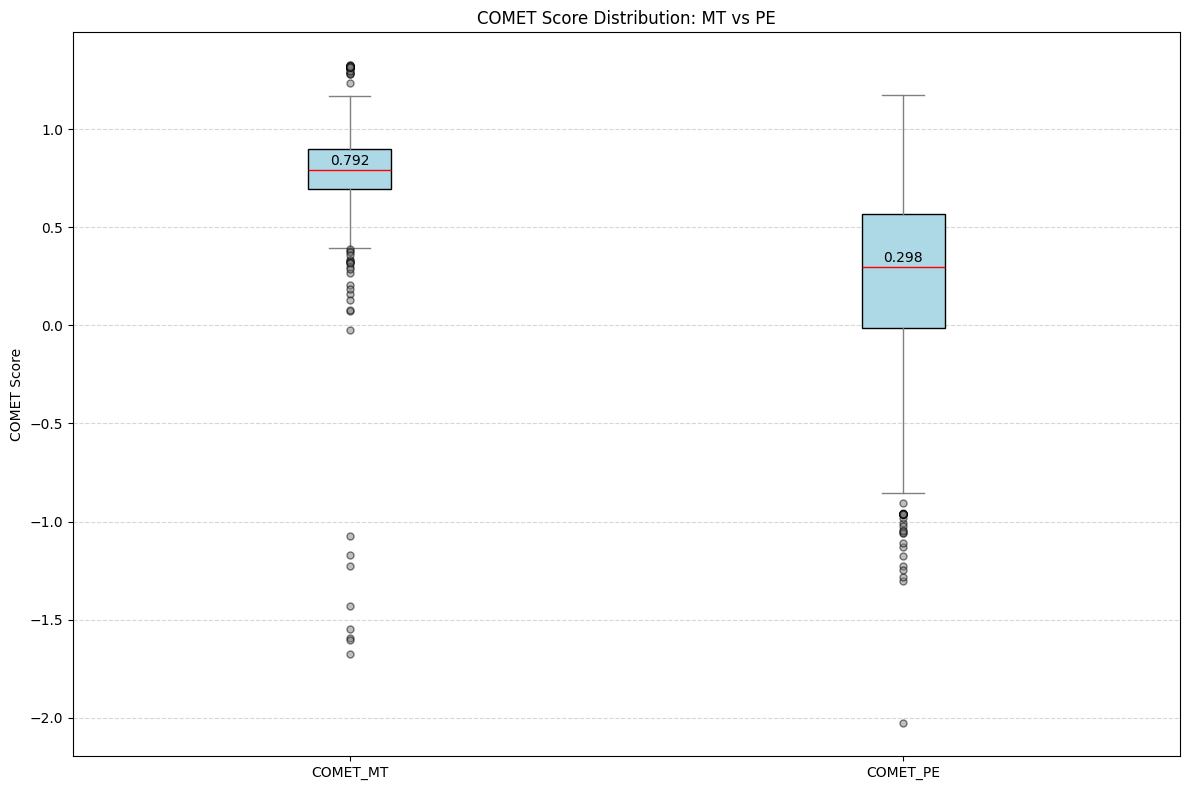

In [16]:
boxdata = [res['COMET_MT'], res['COMET_PE']]
labels = ['COMET_MT', 'COMET_PE']
medians = [s.median() for s in data]

plt.figure(figsize=(12, 8))
box = plt.boxplot(boxdata, tick_labels=labels, patch_artist=True,
                  boxprops=dict(facecolor='lightblue'),
                  medianprops=dict(color='red'),
                  whiskerprops=dict(color='gray'),
                  capprops=dict(color='gray'),
                  flierprops=dict(marker='o', markerfacecolor='gray', markersize=5, alpha=0.5))

# Annotate median values
for i, median in enumerate(medians, start=1):  # boxplot x positions start at 1
    plt.text(i, median + 0.01, f"{median:.3f}", ha='center', va='bottom', fontsize=10, color='black')

plt.ylabel('COMET Score')
plt.title('COMET Score Distribution: MT vs PE')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


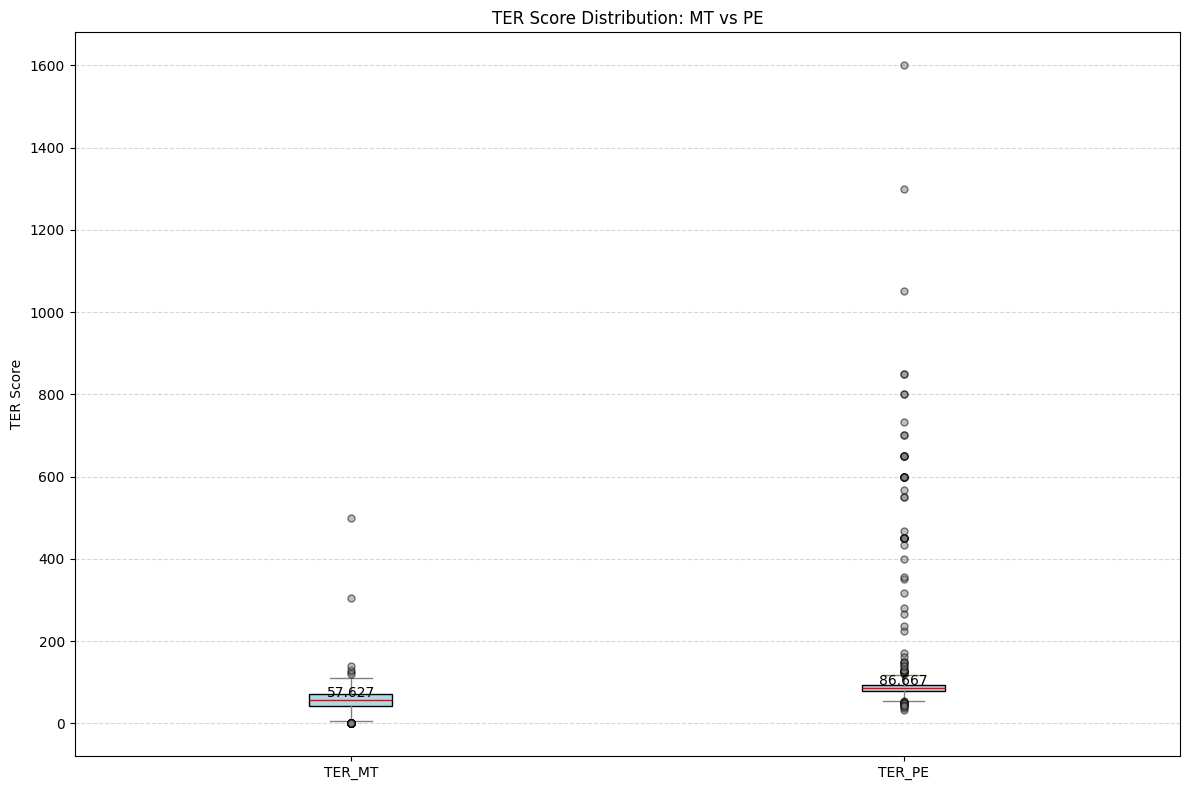

In [18]:
boxdata = [res['TER_MT'], res['TER_PE']]
labels = ['TER_MT', 'TER_PE']
medians = [s.median() for s in data]

plt.figure(figsize=(12, 8))
box = plt.boxplot(boxdata, tick_labels=labels, patch_artist=True,
                  boxprops=dict(facecolor='lightblue'),
                  medianprops=dict(color='red'),
                  whiskerprops=dict(color='gray'),
                  capprops=dict(color='gray'),
                  flierprops=dict(marker='o', markerfacecolor='gray', markersize=5, alpha=0.5))

for i, median in enumerate(medians, start=1):  # boxplot x positions start at 1
    plt.text(i, median + 0.01, f"{median:.3f}", ha='center', va='bottom', fontsize=10, color='black')

plt.ylabel('TER Score')
plt.title('TER Score Distribution: MT vs PE')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [128]:
average_delta_abs_COMET = (res["COMET_MT"] - res["COMET_PE"]).abs().mean()
print(f"Average absolute delta (COMET_MT ‚àí COMET_PE): {average_delta_abs_COMET:.4f}")
average_delta_abs_TER = (res["TER_MT"] - res["TER_PE"]).abs().mean()
print(f"Average absolute delta (TER_MT ‚àí TER_PE): {average_delta_abs_TER:.4f}")


Average absolute delta (COMET_MT ‚àí COMET_PE): 0.6121
Average absolute delta (TER_MT ‚àí TER_PE): 75.0284


In [9]:
max_delta_abs_COMET = (res["COMET_MT"] - res["COMET_PE"]).abs().max()
print(f"Maximum absolute delta (COMET_MT ‚àí COMET_PE): {max_delta_abs_COMET:.4f}")
max_delta_abs_TER = (res["TER_MT"] - res["TER_PE"]).abs().max()
print(f"Maximum absolute delta (TER_MT ‚àí TER_PE): {max_delta_abs_TER:.4f}")

Maximum absolute delta (COMET_MT ‚àí COMET_PE): 2.9583
Maximum absolute delta (TER_MT ‚àí TER_PE): 1550.0000


In [10]:
res["COMET_DELTA_ABS"] = (res["COMET_MT"] - res["COMET_PE"]).abs()

# Find the index of the max delta
max_delta_idx = res["COMET_DELTA_ABS"].idxmax()

# Print the row and the delta
print("Row with max absolute COMET delta:")
print(res.loc[max_delta_idx])
print(f"\n Max absolute COMET delta: {res.loc[max_delta_idx, 'COMET_DELTA_ABS']:.4f}")

Row with max absolute COMET delta:
FR                 2. Les √âtats Membres devraient respecter les p...
RU_GOLD            2. –ì–æ—Å—É–¥–∞—Ä—Å—Ç–≤–∞-—á–ª–µ–Ω—ã –¥–æ–ª–∂–Ω—ã —Å–æ–±–ª—é–¥–∞—Ç—å —Å–ª–µ–¥—É—é—â–∏...
RU_MT              2. –ì–æ—Å—É–¥–∞—Ä—Å—Ç–≤–∞-—á–ª–µ–Ω—ã –¥–æ–ª–∂–Ω—ã —Å–æ–±–ª—é–¥–∞—Ç—å –ø—Ä–∏–Ω—Ü–∏–ø—ã...
FR_TERMS           [√âtats Membres, D√©claration de Rio sur l'envir...
RU_TERMS_GOLD      [–≥–æ—Å—É–¥–∞—Ä—Å—Ç–≤–∞-—á–ª–µ–Ω—ã, –†–∏–æ-–¥–µ-–ñ–∞–Ω–µ–π—Ä—Å–∫–∞—è –¥–µ–∫–ª–∞—Ä–∞—Ü...
COMET_MT                                                    0.929502
TER_MT                                                     23.076923
RU_PE              –ì–æ—Å—É–¥–∞—Ä—Å—Ç–≤–∞-—á–ª–µ–Ω—ã –æ–±—è–∑–∞–Ω—ã —Å–æ–±–ª—é–¥–∞—Ç—å –ø—Ä–∏–Ω—Ü–∏–ø—ã, ...
COMET_PE                                                   -2.028844
TER_PE                                                    354.945055
COMET_DELTA_ABS                                             2.958346
Name: 347, dtype: object

 Max absolute COMET 

In [126]:
res["TER_DELTA_ABS"] = (res["TER_MT"] - res["TER_PE"]).abs()

# Find the index of the max delta
max_delta_idx = res["TER_DELTA_ABS"].idxmax()

# Print the row and the delta
print("Row with max absolute TER delta:")
print(res.loc[max_delta_idx])
print(f"\n Max absolute TER delta: {res.loc[max_delta_idx, 'TER_DELTA_ABS']:.4f}")

Row with max absolute TER delta:
FR                                                R√âSOLUTION 62/93
RU_GOLD                                            –†–ï–ó–û–õ–Æ–¶–ò–Ø 62/93
RU_MT                                 –§—Ä–∞–Ω—Ü—É–∑—Å–∫–∏–π: –†–ï–ó–û–õ–Æ–¶–ò–Ø 62/93
FR_TERMS                                            ['R√âSOLUTION']
RU_TERMS_GOLD                                        ['–†–ï–ó–û–õ–Æ–¶–ò–Ø']
COMET_MT                                                  0.639425
TER_MT                                                        50.0
RU_PE            –†–µ–∑–æ–ª—é—Ü–∏—è 62/93 ‚Äî —ç—Ç–æ –¥–æ–∫—É–º–µ–Ω—Ç –û–û–ù, –∫–æ—Ç–æ—Ä—ã–π –±—ã...
COMET_PE                                                 -1.059084
TER_PE                                                      1600.0
TER_DELTA_ABS                                               1550.0
Name: 153, dtype: object

 Max absolute TER delta: 1550.0000


### Segement line chart

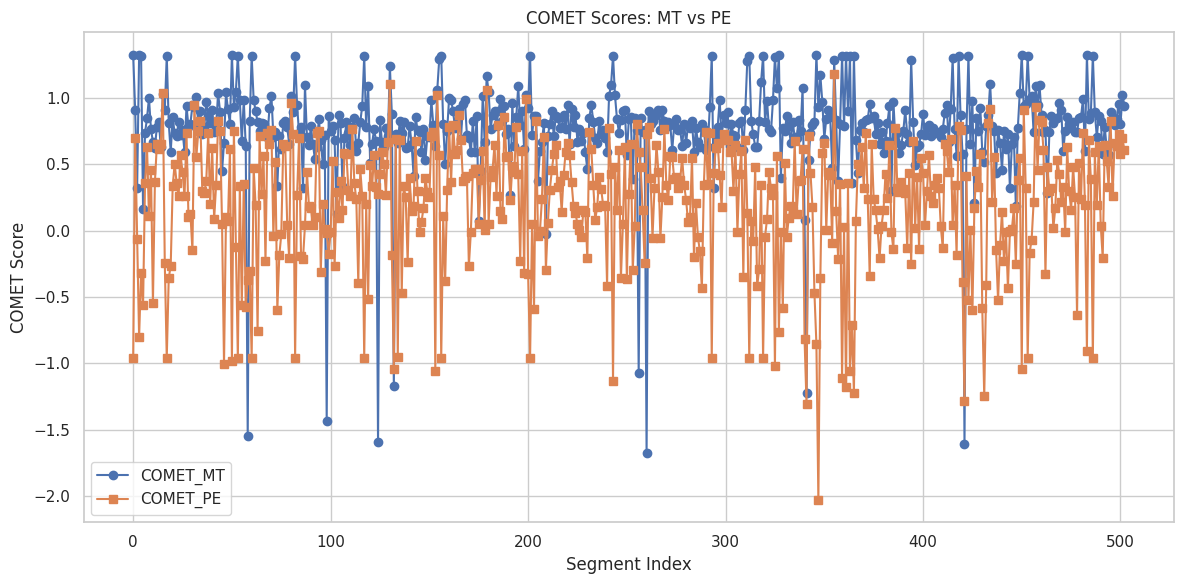

In [111]:
plt.figure(figsize=(12, 6))
plt.plot(res["COMET_MT"], label="COMET_MT", marker="o")
plt.plot(res["COMET_PE"], label="COMET_PE", marker="s")
plt.title("COMET Scores: MT vs PE")
plt.xlabel("Segment Index")
plt.ylabel("COMET Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


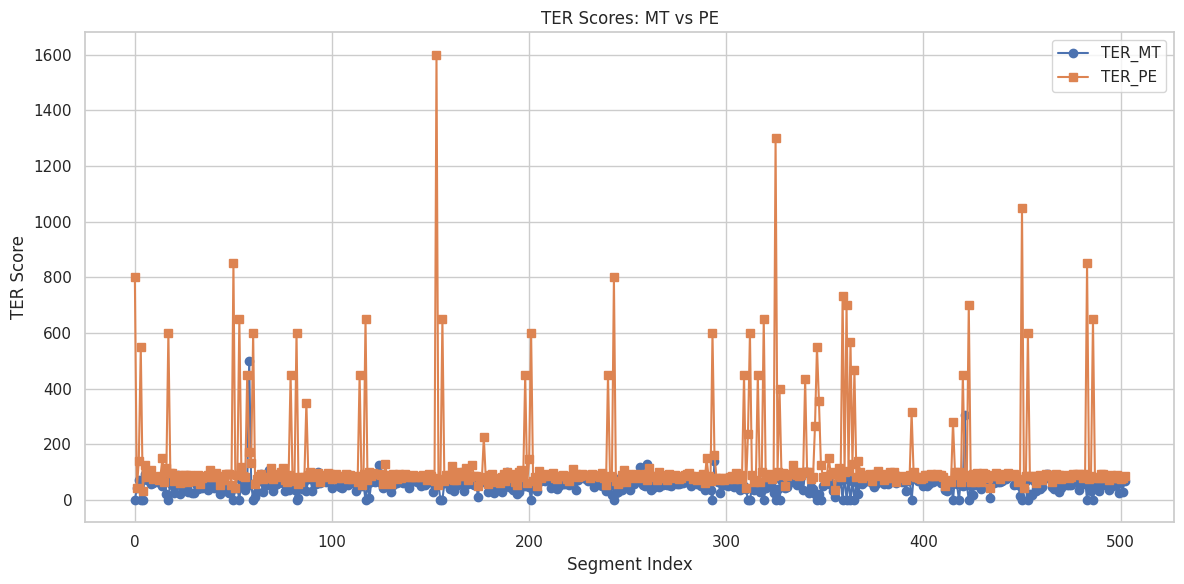

In [112]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(res["TER_MT"], label="TER_MT", marker="o")
plt.plot(res["TER_PE"], label="TER_PE", marker="s")
plt.title("TER Scores: MT vs PE")
plt.xlabel("Segment Index")
plt.ylabel("TER Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
